In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica Light'
plt.rc('axes', unicode_minus=False)

import sys
sys.path.append('../d03_src/')
import vars
import process_graph
import process_demographics
from evaluate_visualization import map

# Processing Demographic Data

In this notebook we detail how we process census demographic data into features of interest. We detail:

- What features we select for demographics in census tracts
- How to use these features to express demographics in geohashes

## 1. Reading Census Data

In [2]:
from pygris import tracts
census_gdf = tracts(state='NY', county=['New York','Bronx','Kings','Queens','Richmond']).set_index('GEOID')

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'
Using FIPS code '085' for input 'Richmond'


In [3]:
def read_table(table, raw_census_data_dir=vars._raw_census_data_dir):
    df = pd.read_csv(f'{raw_census_data_dir}{table}.csv', low_memory=False).iloc[1:]
    df['GEOID'] = df['GEO_ID']
    df = df.set_index(df['GEOID'].apply(lambda x: str(x)[-11:]))
    return df

For demographic values, I am using census 2020 tables P1, P9, P10, P13, H4 as well as ACS 2020 5-year estimates S1901, B15003, B25003

In [4]:
census_covariates = pd.DataFrame()
census_covariates_counts = pd.DataFrame() #will be useful for geohash!

Population:

In [5]:
#Get total population:
pop_table = read_table('P1')
pop_col = pop_table['P1_001N'].astype(int)

census_covariates['population'] = pop_col
census_covariates_counts['population'] = pop_col

Income:

In [6]:
#Getting the median income:
ACS_inc_table = read_table('S1901')
med_inc = ACS_inc_table.loc[:,'S1901_C01_012E']
med_inc_col = med_inc.replace({'-':1, '2,500-':2500, '250,000+': 250000}).astype(int)

census_covariates['income_median'] = med_inc_col
census_covariates_counts['income_median'] = med_inc_col

#Categorical income:
census_covariates['income_qt'] = pd.qcut(census_covariates['income_median'], 4, labels=['lowest', '2nd lowest', '2nd highest', 'highest'])

Poverty status:

In [7]:
#Getting the population under poverty level:
ACS_poverty_table = read_table('S1701')
pop_total = ACS_poverty_table.loc[:,'S1701_C01_001E'].astype(float)
pop_poverty = ACS_poverty_table.loc[:,'S1701_C02_001E'].astype(float)

census_covariates_counts['income_poverty'] = pop_poverty.fillna(0)
census_covariates['income_poverty_pct'] = (pop_poverty/pop_total).fillna(0)

Education:

In [8]:
#Getting the pct of population with a bachelor's degree:
bachelors_or_more = [f'B15003_0{n:02}E' for n in range(22, 26)]
no_highschool = [f'B15003_0{n:02}E' for n in range(2, 17)]

ACS_ed_table = read_table('B15003')
total_ed = ACS_ed_table.loc[:,'B15003_001E'].astype(int)

census_covariates['education_bachelors_pct'] = ACS_ed_table.loc[:,bachelors_or_more].astype(int).sum(axis=1)/total_ed
census_covariates['education_nohighschool_pct'] = ACS_ed_table.loc[:,no_highschool].astype(int).sum(axis=1)/total_ed


census_covariates_counts['education_bachelors'] = ACS_ed_table.loc[:,bachelors_or_more].astype(int).sum(axis=1).fillna(0)
census_covariates_counts['education_nohighschool'] = ACS_ed_table.loc[:,no_highschool].astype(int).sum(axis=1).fillna(0)

Compute the race using the race and ethnicity (preferred) tables

In [9]:
#Getting the pct of population identifying as white alone:
race_table = read_table('P10')
total_race = race_table.loc[:,'P10_002N'].astype(int)
census_covariates['race_white_pct'] = race_table.loc[:,'P10_003N'].astype(int)/total_race

#Getting the pct of population identifying as white (non-hispanic) alone:
race_ethnicity_table = read_table('P9')
total_ethnicity = race_ethnicity_table.loc[:,'P9_001N'].astype(int)
census_covariates['race_hispanic_pct'] = race_ethnicity_table.loc[:,'P9_002N'].astype(int)/total_ethnicity
census_covariates['race_white_nh_pct'] = race_ethnicity_table.loc[:,'P9_005N'].astype(int)/total_ethnicity
census_covariates['race_black_nh_pct'] = race_ethnicity_table.loc[:,'P9_006N'].astype(int)/total_ethnicity
census_covariates['race_asian_nh_pct'] = race_ethnicity_table.loc[:,'P9_008N'].astype(int)/total_ethnicity
census_covariates['race_other_nh_pct'] = race_ethnicity_table.loc[:,['P9_007N', 'P9_009N', 'P9_010N']].astype(int).sum(axis=1)/total_ethnicity

#Counts:
census_covariates_counts['race_hispanic'] = race_ethnicity_table.loc[:,'P9_002N'].astype(int).fillna(0)
census_covariates_counts['race_white_nh'] = race_ethnicity_table.loc[:,'P9_005N'].astype(int).fillna(0)
census_covariates_counts['race_black_nh'] = race_ethnicity_table.loc[:,'P9_006N'].astype(int).fillna(0)
census_covariates_counts['race_asian_nh'] = race_ethnicity_table.loc[:,'P9_008N'].astype(int).fillna(0)
census_covariates_counts['race_other_nh'] = race_ethnicity_table.loc[:,['P9_007N', 'P9_009N', 'P9_010N']].astype(int).sum(axis=1).fillna(0)

#Categorical race:
race_columns = [c for c in census_covariates.columns if 'race' in c and c != 'race_white_pct']
race_map = {race:race.split('_')[1] for race in race_columns}
census_covariates['race_majority'] = census_covariates[race_columns].idxmax(axis=1).map(race_map)

Age:

In [10]:
#Getting median age of the population:
age_table = read_table('P13')
census_covariates['age_median'] = age_table.loc[:,'P13_001N'].replace({'-':0}).astype(float)
census_covariates_counts['age_median'] = age_table.loc[:,'P13_001N'].replace({'-':0}).astype(float)

Home ownership:

In [11]:
#Getting pct of households occupied by owner and renter (don't use both):
household_table = read_table('B25003')
census_covariates['households_owneroccupied_pct']  = household_table.loc[:,'B25003_002E'].astype(int)/household_table.loc[:,'B25003_001E'].astype(int)
census_covariates['households_renteroccupied_pct'] = household_table.loc[:,'B25003_003E'].astype(int)/household_table.loc[:,'B25003_001E'].astype(int)

census_covariates_counts['households'] = household_table.loc[:,'B25003_001E'].astype(int).fillna(0)
census_covariates_counts['households_owneroccupied']  = household_table.loc[:,'B25003_002E'].astype(int).fillna(0)
census_covariates_counts['households_renteroccupied'] = household_table.loc[:,'B25003_003E'].astype(int).fillna(0)

Compute the density:

In [12]:
#Getting the population density:
land_area = census_gdf[['ALAND']].astype(float).rename({'ALAND':'area_m2'},axis=1) #unit: m2
census_covariates = census_covariates.merge(land_area, right_index=True, left_index=True)
census_covariates['population_density'] = (census_covariates['population']/census_covariates['area_m2']).fillna(0)
census_covariates_counts = census_covariates_counts.merge(census_covariates[['area_m2']], right_index=True, left_index=True)

Georeference the covariates (cropping to our graph):

In [13]:
#This is the graph we use in the paper experiments:
gdf_census_paper, _ = process_graph.generate_graph_census(remove_zeropop=True, tresh_population=100,
                                                          remove_parks=True, tresh_parkarea=3/4,
                                                          remove_water=True)
gdf_census_paper['GEOID'] = gdf_census_paper['GEOID'].astype(int)
census_covariates.index = census_covariates.index.astype(int)

covariates_names = ['log_population', 'population_density', 'area_m2', 'age_median',
                    'income_median', 'income_poverty_pct',
                    'education_nohighschool_pct', 'education_bachelors_pct',
                    'race_white_nh_pct', 'race_hispanic_pct', 'race_black_nh_pct', 'race_asian_nh_pct', 'race_other_nh_pct',
                    'households_owneroccupied_pct', 'households_renteroccupied_pct']

nyc_covariates_arr = process_demographics.include_covariates(gdf_census_paper,
                                                             covariates_df=census_covariates,
                                                             covariates_names=covariates_names,
                                                             standardize=False)
nyc_covariates_df = gpd.GeoDataFrame(nyc_covariates_arr,
                                     columns=[vars._covariates_names[cov] for cov in covariates_names],
                                     geometry=gdf_census_paper.geometry,
                                     crs=gdf_census_paper.crs)

for col in nyc_covariates_df.columns:
    if '%' in col: nyc_covariates_df[col] *= 100

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'
Using FIPS code '085' for input 'Richmond'


/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 5 islands with ids: 70, 150, 869, 1120, 1530.
  warnings.warn(message)


Now we print summaries:

In [14]:
display(round(nyc_covariates_df.describe().T,3)[['mean', 'std', '25%', '75%']])

,mean,std,25%,75%
log(Population),8.162,0.519,7.828,8.528
Population density,0.021,0.014,0.011,0.029
Land area,283996.758,396845.620,151006.000,262496.000
Median age,37.879,5.822,34.300,40.900
Median income,73909.450,37072.846,49659.000,90979.000
Population living below the poverty level (%),16.432,12.186,7.492,22.652
Population without a highschool degree (%),17.421,11.373,8.950,24.538
Population with a bachelor's degree (%),36.906,21.310,21.254,47.913
White population (%),30.339,27.396,4.090,54.020
Hispanic population (%),26.866,21.042,10.858,37.717


In the SI we show the following maps for racial distribution:

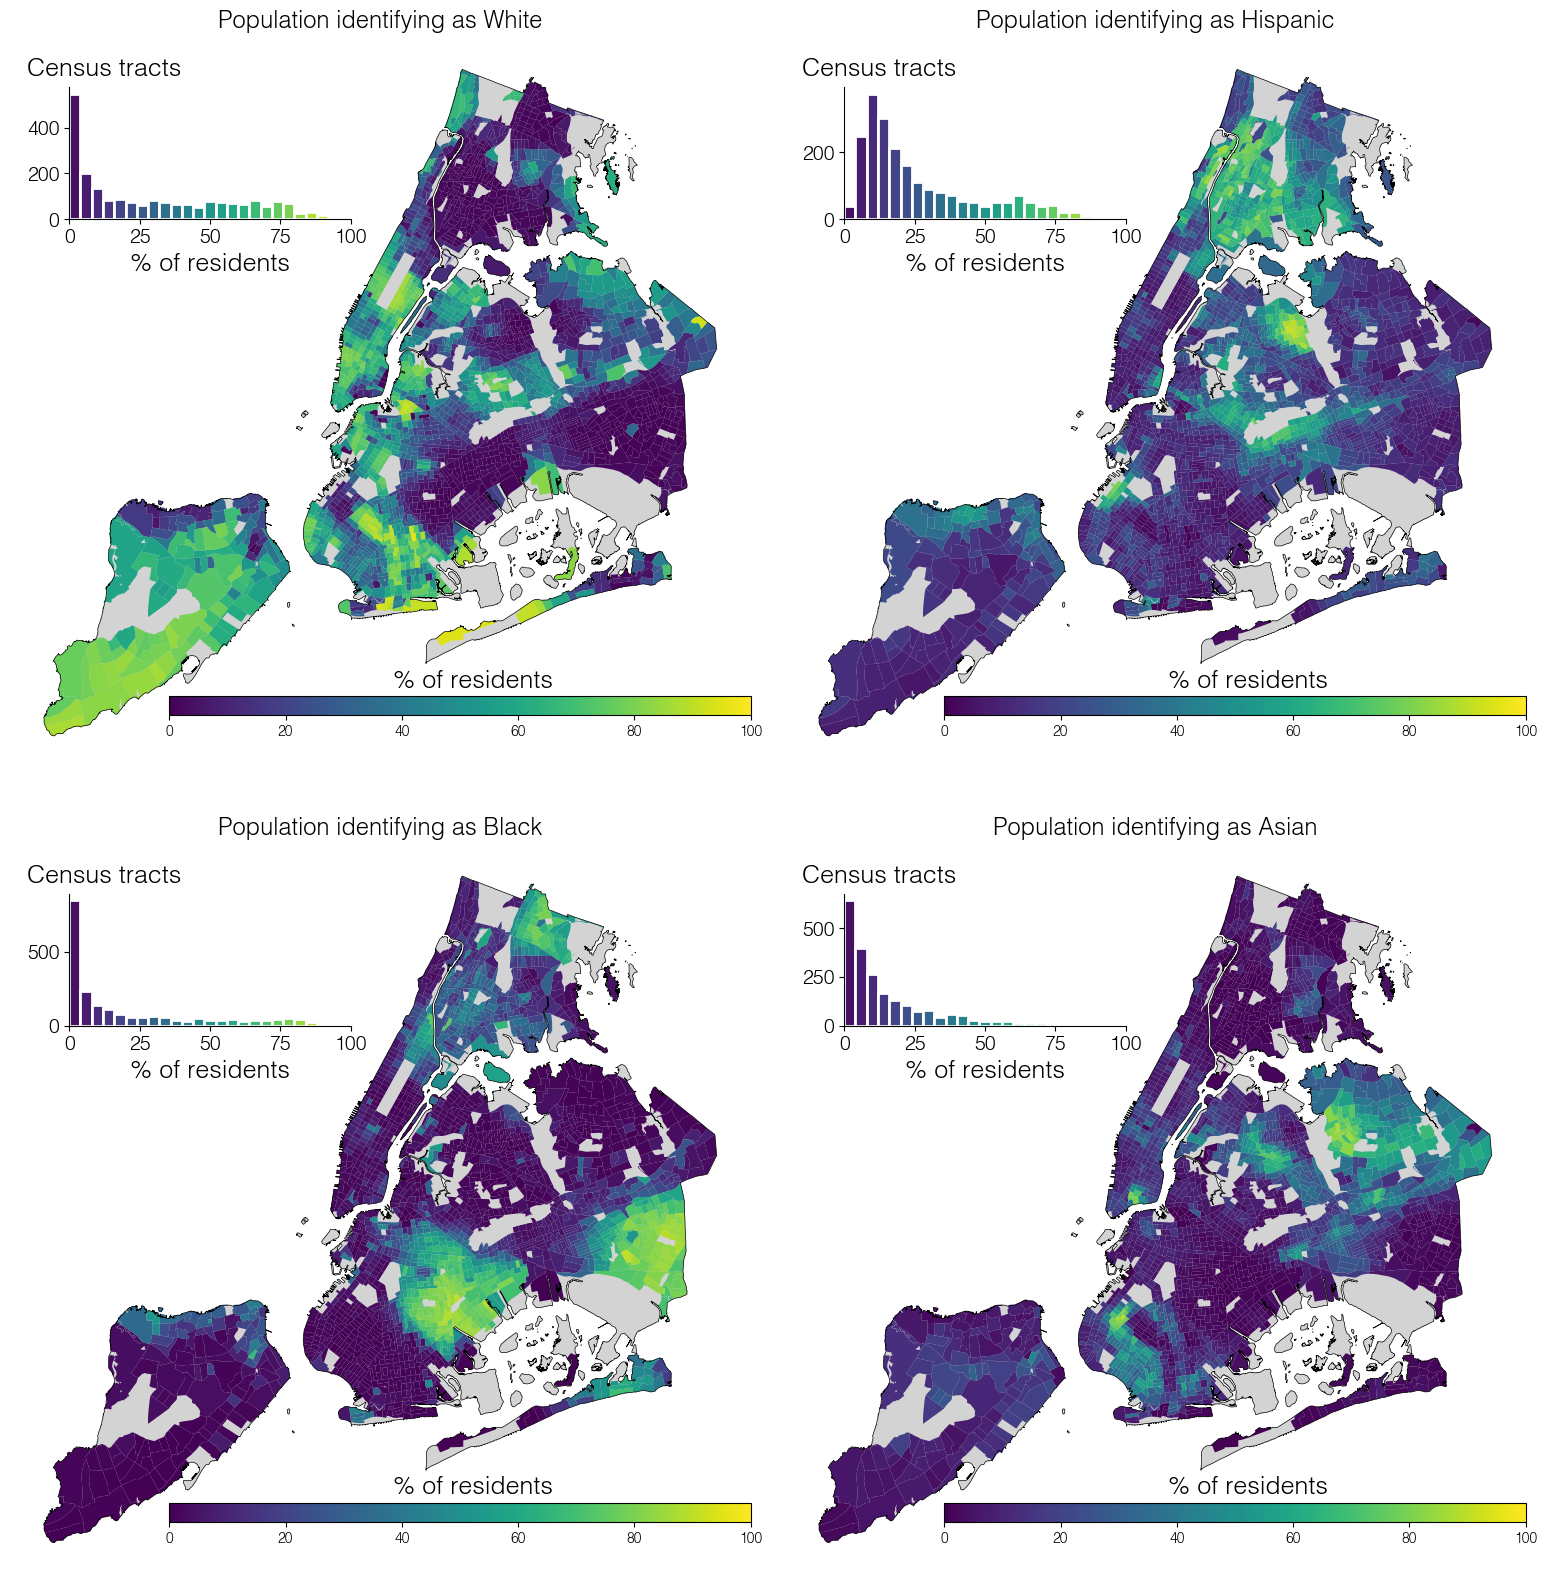

In [15]:
#Get the base gdf:
nyc_boroughs = gpd.read_file('../d01_data/d01_raw/d02_spatial-data/NYC-boroughs/NYC-boroughs.shp')
nyc_boundary = gpd.GeoDataFrame(geometry=[nyc_boroughs.unary_union], crs=nyc_boroughs.crs).to_crs(nyc_covariates_df.crs)

#Create a figure for the 4 racial groups:
fig, Axes = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)

#Iterate and plot with our map function:
for race, ax in zip(['white', 'hispanic', 'black', 'asian'] , Axes.flatten()):
    values=nyc_covariates_df[f'{race.capitalize()} population (%)'].values
    ax = map(values,
             values_vmax=100,
             values_name='% of residents',
             gdf=nyc_covariates_df,
             base_gdf=nyc_boundary,
             cmap_name='viridis',
             special_class=False,
             hist_plot=True,
             title=f"Population identifying as {race.capitalize()}",
             show=False,
             ax=ax,
             save=False,
             legend_nodata=False)

plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('../d07_plots/SI_race.pdf', pad_inches=0.05, bbox_inches='tight', format='pdf')
plt.show()

The above was saved to the processed data directory, and the covariates can be accessed through:

In [16]:
covariates = process_demographics.get_covariates()
covariates.head()

,population,income_median,income_qt,income_poverty_pct,education_bachelors_pct,education_nohighschool_pct,race_white_pct,race_hispanic_pct,race_white_nh_pct,race_black_nh_pct,race_asian_nh_pct,race_other_nh_pct,race_majority,age_median,households_owneroccupied_pct,households_renteroccupied_pct,area_m2,population_density
GEOID,,,,,,,,,,,,,,,,,,
36001000100,2073,45268,lowest,0.242000,0.191544,0.216566,0.234012,0.124457,0.178485,0.596237,0.020260,0.008201,black,34.7,0.364109,0.635891,2367456.0,0.000876
36001000201,3125,37500,lowest,0.268771,0.375656,0.125393,0.242909,0.110400,0.181120,0.600000,0.033280,0.020480,black,33.0,0.191751,0.808249,615867.0,0.005074
36001000202,2598,25290,lowest,0.345060,0.092699,0.123052,0.111797,0.158968,0.070824,0.694765,0.023480,0.005774,black,29.6,0.281490,0.718510,1441490.0,0.001802
36001000301,3190,36964,lowest,0.376989,0.085873,0.195014,0.223174,0.164263,0.155799,0.565831,0.027586,0.013480,black,31.0,0.274009,0.725991,659499.0,0.004837
36001000302,3496,42266,lowest,0.187241,0.373176,0.043294,0.632793,0.108696,0.548055,0.184783,0.102403,0.009439,white,32.5,0.369716,0.630284,5097939.0,0.000686


## 2. Casting demographics to geohash

In [17]:
geohash_gdf, _ = process_graph.generate_graph_geohash(precision=6,
                                                      remove_zeropop=False,
                                                      remove_parks=False,
                                                      remove_water=False)

/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There is 1 island with id: 1492.
  warnings.warn(message)


When doing our analysis for geohashes, one important consideration is how to assign demographic and socioeconomic variables to these geometries---features that are only available at the census tract level. We opt for projecting the features onto geohashes with the following strategy:

1. Collect the raw counts of features per census tract i.e. count of population, count of Black population, count of people with no high school degree (rather than percentages)
2. Compute the area of each census tract that intersects each geohash, and the corresponding population from that tract living in the hash (assuming that the population is uniformly distributed)
3. Weight each covariate by population (except for household covariates, which we simply weight by area)

The raw counts can be accessed as follows (and then georeferenced):

In [18]:
covariates_df = process_demographics.get_covariates(table='GEOID_covariates_rawcount')
covariates_df.index = covariates_df.index.astype(int)
census_gdf.index = census_gdf.index.astype(int)
census_with_covariates_gdf = census_gdf.merge(covariates_df, left_index=True, right_index=True, how='left')

Defining covariates:

In [19]:
#These covariates will be weighted by the area i.e. we are assuming a uniform distribution on each tract:
area_covariates = {cov:None for cov in ['population',
                                        'households',
                                        'income_poverty',
                                        'education_bachelors',
                                        'education_nohighschool',
                                        'race_hispanic',
                                        'race_white_nh',
                                        'race_black_nh',
                                        'race_asian_nh',
                                        'race_other_nh',
                                        'households_owneroccupied',
                                        'households_renteroccupied']}

#These covariates will be weighted by the population:
population_covariates = {cov:'population' for cov in ['income_median', 'age_median']}

w_col = area_covariates|population_covariates
covariates = list(w_col.keys())

Now, to attach to geohash, we use the function `project_demographics`. This is a very versatile function that can be used whenever the problem of "casting demographics" appears. Note that we can't have any non-numeric column here:

In [20]:
df = process_demographics.project_demographics(geohash_gdf,
                                               census_with_covariates_gdf,
                                               demographic_cols=covariates,
                                               weighting_col=w_col)

To retrieve geohash demographics, one can use the `get_covariates` function with the appropriate table:

In [21]:
covariates = process_demographics.get_covariates(table='geohash_6_covariates')
covariates.head()

,area_m2,population,households,income_poverty,education_bachelors,education_nohighschool,race_hispanic,race_white_nh,race_black_nh,race_asian_nh,...,income_poverty_pct,education_bachelors_pct,education_nohighschool_pct,race_hispanic_pct,race_white_nh_pct,race_black_nh_pct,race_asian_nh_pct,race_other_nh_pct,households_owneroccupied_pct,households_renteroccupied_pct
geohash,,,,,,,,,,,,,,,,,,,,,
dr5qu9,6.108467e+06,237.148764,87.434511,94.894202,57.422268,75.984754,43.543775,110.507507,57.422268,15.613306,...,0.400146,0.242136,0.320410,0.183614,0.465984,0.242136,0.065838,0.008047,0.000000,1.000000
dr5rx8,6.096997e+06,8584.858621,2606.944329,814.919499,1869.412295,1231.755970,4682.869042,1254.094813,564.244343,1379.900102,...,0.094925,0.217757,0.143480,0.545480,0.146082,0.065726,0.160736,0.049198,0.535060,0.464940
dr7802,6.089021e+06,4255.355642,1476.171080,235.911606,974.951618,495.778756,713.894145,2038.983276,43.747583,1385.013415,...,0.055439,0.229112,0.116507,0.167764,0.479157,0.010281,0.325475,0.004520,0.550103,0.449897
dr5xf3,6.092487e+06,1820.280725,605.205545,165.586819,580.948985,198.336222,207.976339,378.770127,161.162010,976.897715,...,0.090968,0.319154,0.108959,0.114255,0.208083,0.088537,0.536674,0.024699,0.678459,0.321541
dr5r4r,6.101468e+06,1920.192538,756.146323,355.173119,429.200198,279.754007,539.901352,405.462467,753.416640,110.223976,...,0.184967,0.223519,0.145691,0.281170,0.211157,0.392365,0.057403,0.013885,0.165801,0.834199


To ensure we have an approximately correct mapping, lets plot some demographics:

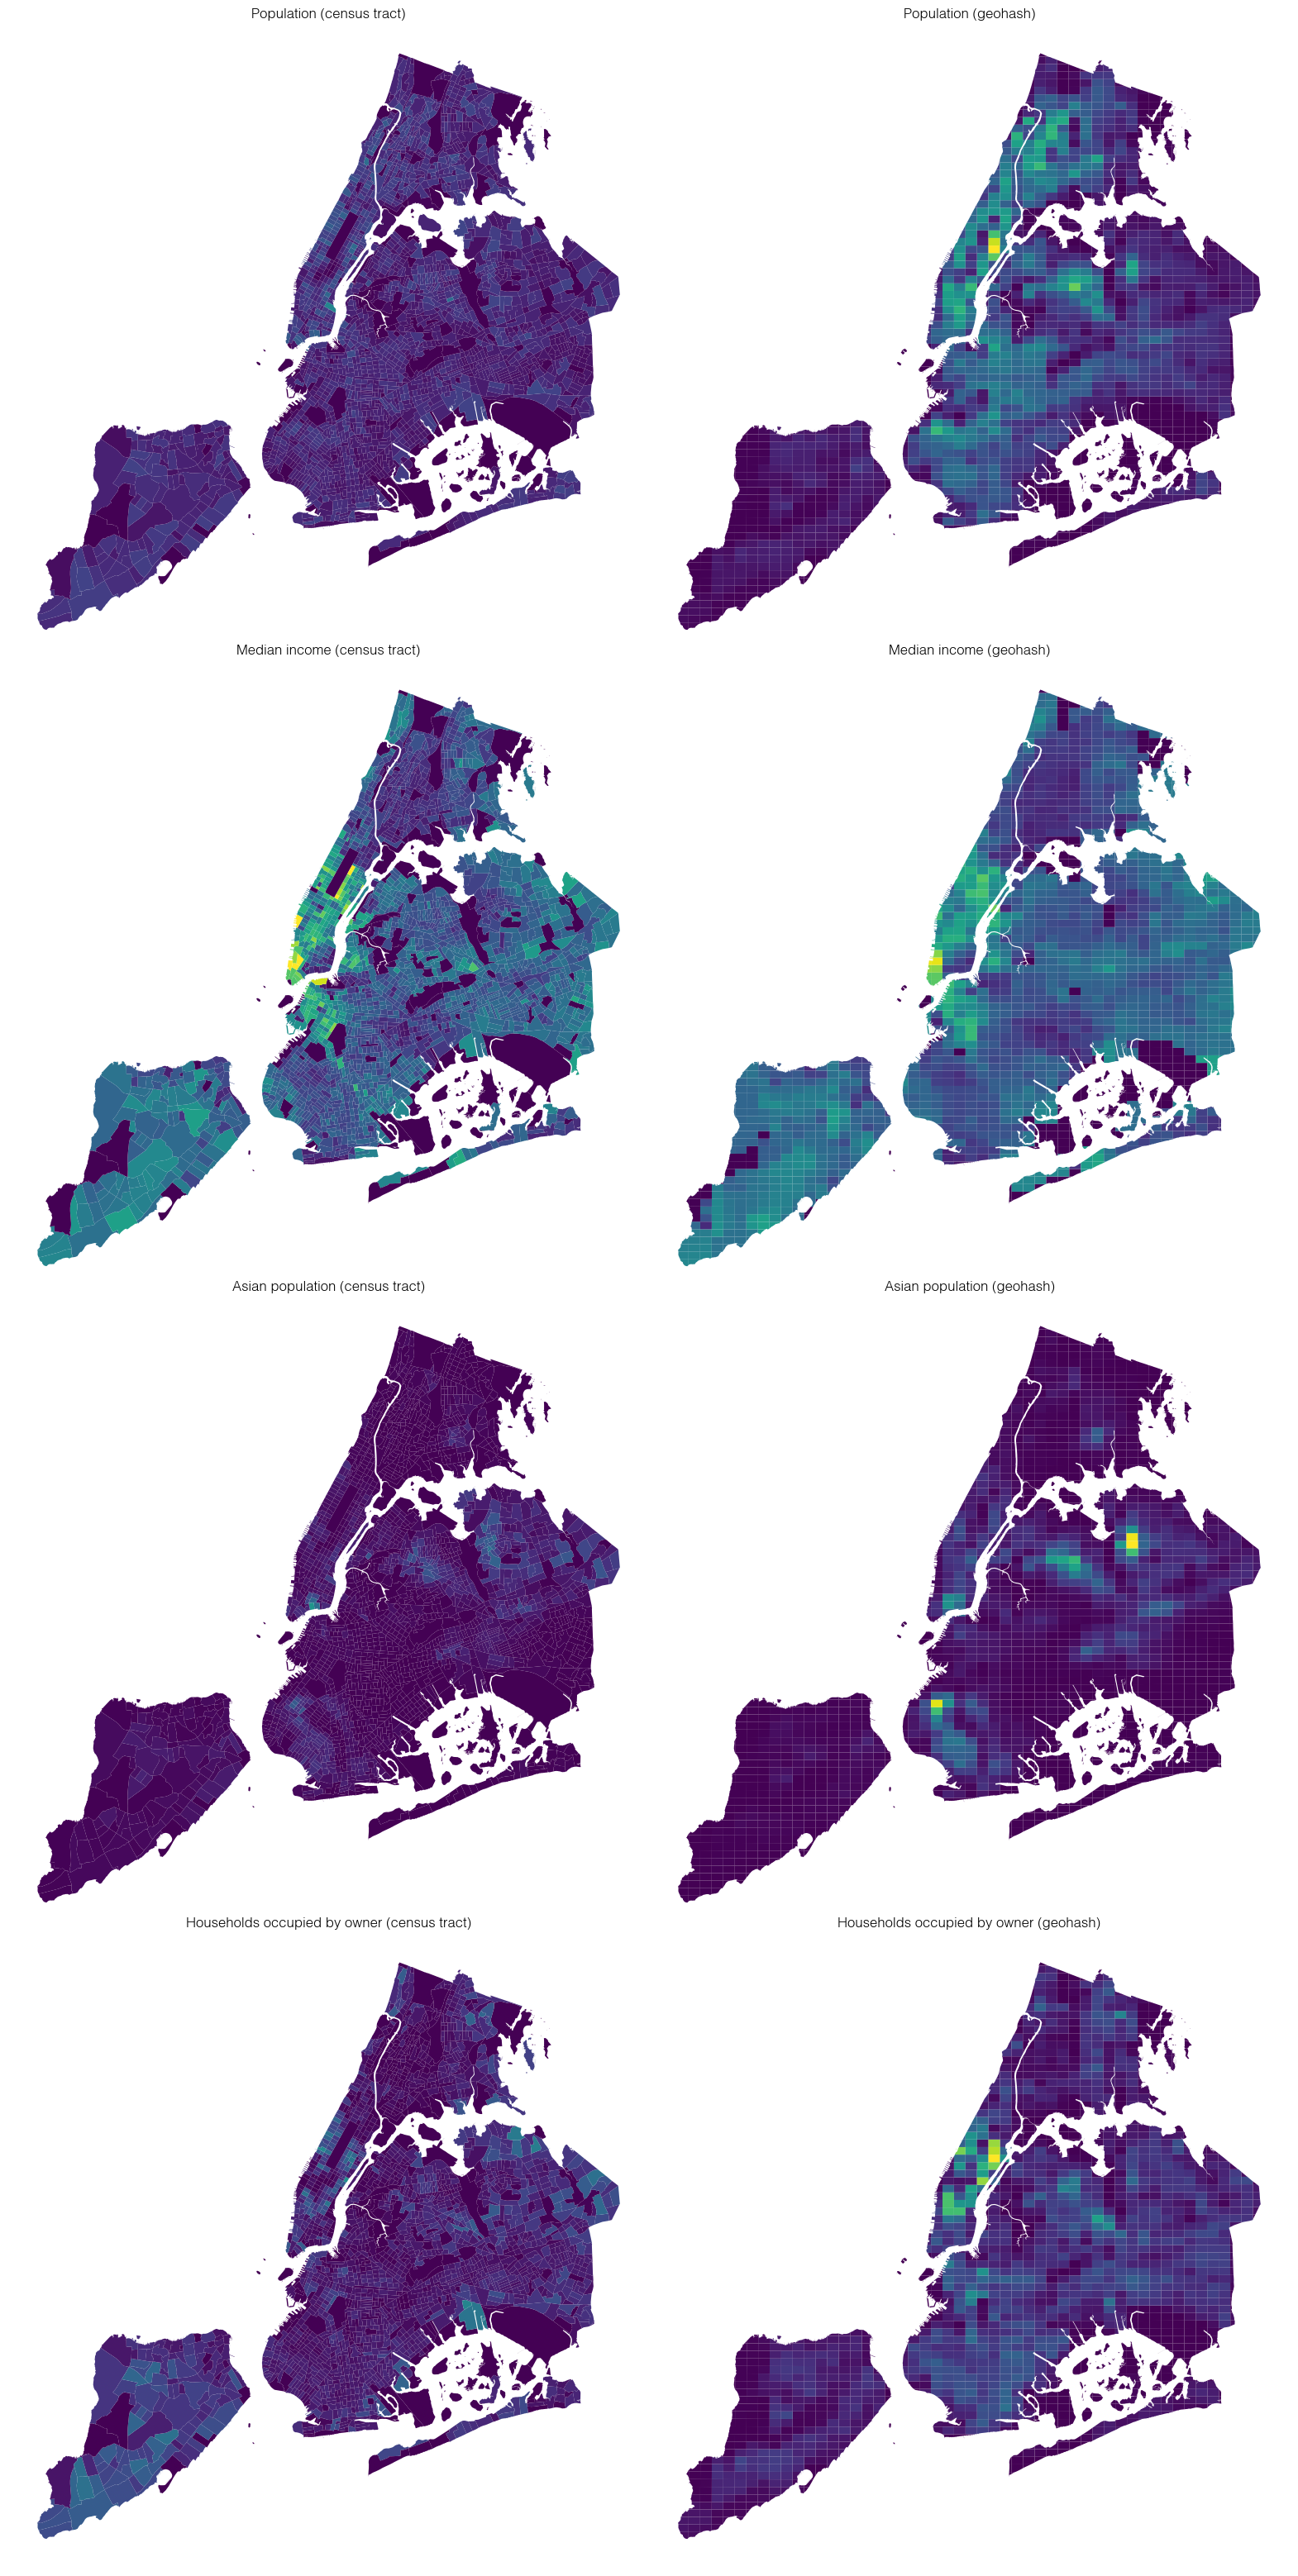

In [22]:
#Get the base gdf:
nyc_boroughs = gpd.read_file('../d01_data/d01_raw/d02_spatial-data/NYC-boroughs/NYC-boroughs.shp')
nyc_boundary = gpd.GeoDataFrame(geometry=[nyc_boroughs.unary_union], crs=nyc_boroughs.crs).to_crs(vars._projected_crs)

#Get census covariates:
covariates_census = process_demographics.get_covariates(table='GEOID_covariates_rawcount')
covariates_census.index = covariates_census.index.astype(int)
covariates_census_gdf = census_gdf[['geometry']].merge(covariates_census, left_index=True, right_index=True, how='left')
covariates_census_clip_gdf = gpd.clip(covariates_census_gdf.to_crs(vars._projected_crs), nyc_boundary)

#Get geohash covariates:
covariates_geohash = process_demographics.get_covariates(table='geohash_6_covariates')
covariates_geohash_gdf = geohash_gdf[['geohash', 'geometry']].merge(covariates_geohash, left_on='geohash', right_index=True, how='left')
covariates_geohash_gdf = covariates_geohash_gdf.set_index('geohash')
covariates_geohash_clip_gdf = gpd.clip(covariates_geohash_gdf.to_crs(vars._projected_crs), nyc_boundary)

#Select a few covariates to visualize:
covariates_to_plot = ['population', 'income_median', 'race_asian_nh', 'households_owneroccupied']

#Create figure and plot:
fig, Axes = plt.subplots(figsize=(20,10*len(covariates_to_plot)), nrows=len(covariates_to_plot), ncols=2)

for ax_row, covariate in zip(Axes, covariates_to_plot):

    #We must colect the minimum and maximum values if we want to make
    # the plots agree on the color scale:
    if 'pct' not in covariate:
        X1 = covariates_census_clip_gdf[covariate].values
        X2 = covariates_geohash_clip_gdf[covariate].values
        vmin, vmax = min(min(X1), min(X2)), max(max(X1),max(X2))
    else:
        vmin, vmax = 0, 1

    #First we plot the census:
    ax = ax_row[0]
    _ = covariates_census_clip_gdf.plot(column=covariate, ax=ax, vmin=vmin, vmax=vmax)
    _ = ax.set_title(vars._covariates_names[covariate]+' (census tract)')
    _ = ax.axis('off')

    #Second we plot the geohash:
    ax = ax_row[1]
    _ = covariates_geohash_clip_gdf.plot(column=covariate, ax=ax, vmin=vmin, vmax=vmax)
    _ = ax.set_title(vars._covariates_names[covariate]+' (geohash)')
    _ = ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()